# Classification task of predicting if the client will subscribe a term deposit

## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, plot_importance
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:,.2f}'.format)

%load_ext autoreload
%autoreload all
from process_bank_deposit import (split_data, create_inputs_and_targets,
                                  get_auc, get_eval_results, get_confusion_matrix)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Appropriate methods and metrics

Since our task is a binary classification problem (predicting customer churn), for the initial baseline model, I prefer using **Logistic Regression**, as it is a simple yet powerful model for classification tasks. Additionally, I plan to experiment with tree-based model (**Random Forest Classifier**) and **Boosting** models (XGBoost, LightGBM).

**Preprocessing Requirements:**
- **Logistic Regression:** Requires scaling and encoding for categorical features.
- **RandomForest Classifier:** Require only encoding.
- **Boosting models:** Can be tested both with and without encoding, as some boosting algorithms can handle categorical features directly.

**Evaluation Metrics:**
- I prefer use the AUC-ROC Score with Stratified k-fold cross-validation as the primary metric to ensure a balanced assessment across unbalanced target.
- Additionally, I will use the Confusion Matrix to analyze classification performance and understand model misclassifications.

## Load the data

In [140]:
raw_data = pd.read_csv('./data/bank_data.csv')

In [3]:
raw_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,cons.price.idx_diff,cons.conf.idx_diff
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,"5,191.00",no,0.00,0.00
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,"5,191.00",no,0.00,0.00
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,"5,191.00",no,0.00,0.00
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,"5,191.00",no,0.00,0.00
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.10,93.99,-36.40,4.86,"5,191.00",no,0.00,0.00


## Split on train and test sets

In [141]:
data_dict = split_data(raw_data, 'y')

In [142]:
print('train_df.shape :', data_dict['train'].shape)
print('test_df.shape :', data_dict['test'].shape)

train_df.shape : (32940, 22)
test_df.shape : (8236, 22)


In [143]:
input_cols = list(raw_data.drop(columns=['duration', 'y']).columns)
target_col = 'y'

In [144]:
data_dict = create_inputs_and_targets(data_dict, input_cols, target_col)

In [145]:
train_inputs, train_targets = data_dict['train_inputs'], data_dict['train_targets']
test_inputs, test_targets = data_dict['test_inputs'], data_dict['test_targets']

## Identify numeric and categorical columns

In [146]:
numeric_cols = train_inputs.select_dtypes(include='number').columns.to_list()
categorical_cols = train_inputs.select_dtypes(include='object').columns.to_list()

## Preprocessing

### Scaling of the numeric columns

In [147]:
scaler = MinMaxScaler()

numerical_transformer = Pipeline(steps=[
    ('scaler', scaler)
])

### Encoding of the categorical columns

In [148]:
encoder = OneHotEncoder(
    sparse_output=False, handle_unknown='ignore'
)

categorical_transformer = Pipeline(steps=[
    ('onehot_enc', encoder)
])

## Baseline `LogisticRegression`

AUROC score on train set:: 0.796
AUROC score on validation set:: 0.791


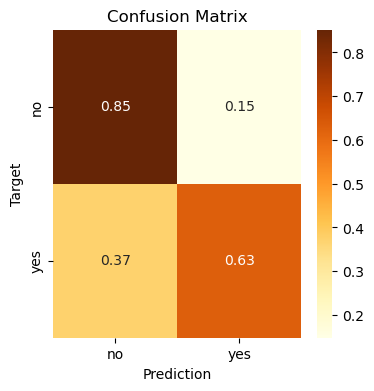

In [12]:
# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
], remainder='passthrough',
verbose_feature_names_out=False)

preprocessor.set_output(transform='pandas')

clf = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

get_auc(model_pipeline, train_inputs, train_targets)

get_confusion_matrix(model_pipeline, train_inputs, train_targets)

The model performs quite well, achieving a balanced trade-off between false positives (15%) and false negatives (37%).
- The relatively high False Negative Rate (37%) means that some positive cases are being missed, which might be critical for work with clients.
- The ROC AUC of 0.791 is promising, but there is room for improvement, especially in reducing false negatives.

**Next Steps:**
- Feature Engineering: Consider creating interaction features or transformations to capture more patterns in the data.
- Alternative Models: Try tree-based models (Random Forest, Gradient Boosting) that can handle complex relationships.

## Feature engineering

In [14]:
train_inputs.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed', 'cons.price.idx_diff',
       'cons.conf.idx_diff'],
      dtype='object')

### Categorize the `age` feature

In [15]:
train_inputs['age'][:10]

36444    24
1233     32
24104    33
15513    38
17912    39
8504     43
24130    57
2680     55
5824     36
37518    57
Name: age, dtype: int64

In [16]:
train_inputs['age_cat'] = (train_inputs['age'] // 10)

In [17]:
train_inputs['age_cat'][:10]

36444    2
1233     3
24104    3
15513    3
17912    3
8504     4
24130    5
2680     5
5824     3
37518    5
Name: age_cat, dtype: int64

In [18]:
train_inputs['age_cat'].value_counts()

age_cat
3    13507
4     8426
5     5440
2     4534
6      594
7      258
8      115
1       56
9       10
Name: count, dtype: int64

### `campaign`

Let's create indicator if the client had only one contact performed during this campaign.

In [19]:
train_inputs['is_only_one_contact'] = (train_inputs['campaign'] == 1).astype(int)

In [20]:
display(train_inputs['campaign'].value_counts()[:5])
display(train_inputs['is_only_one_contact'].value_counts())

campaign
1    14158
2     8409
3     4280
4     2094
5     1292
Name: count, dtype: int64

is_only_one_contact
0    18782
1    14158
Name: count, dtype: int64

In [21]:
display(train_inputs['campaign'].value_counts()[:7])

campaign
1    14158
2     8409
3     4280
4     2094
5     1292
6      796
7      510
Name: count, dtype: int64

Let's also create an indicator feature for clients who had more than 6 contacts during this campaign, as they could be considered outliers.

In [22]:
train_inputs['more_than_six_contacts'] = (train_inputs['campaign'] > 6).astype(int)
train_inputs['more_than_six_contacts'].value_counts()

more_than_six_contacts
0    31029
1     1911
Name: count, dtype: int64

### `previous`

In [23]:
train_inputs['previous'].value_counts()

previous
0    28431
1     3660
2      592
3      175
4       61
5       15
6        5
7        1
Name: count, dtype: int64

Let's create a new binary feature, `previous_contact`, to indicate whether the client was contacted before.

In [24]:
train_inputs['previous_contact'] = (train_inputs['previous'] > 0).astype(int)
train_inputs['previous_contact'].value_counts()

previous_contact
0    28431
1     4509
Name: count, dtype: int64

### `pdays`

Let's add information about recent contact (`pdays < 7`)


In [25]:
train_inputs['recent_contact'] = (train_inputs['pdays'] < 7).astype(int)

In [26]:
train_inputs['recent_contact'].value_counts()

recent_contact
0    32059
1      881
Name: count, dtype: int64

Additionally, let's create additional indicator features to mark whether is 3 or 6 days have passed since the client was last contacted from a previous campaign.

In [27]:
train_inputs['pdays_3'] = (train_inputs['pdays'] == 3).astype(int)
train_inputs['pdays_6'] = (train_inputs['pdays'] == 6).astype(int)

### `education`

In [28]:
train_inputs['education'].unique()

array(['professional.course', 'university.degree', 'basic.9y',
       'high.school', 'basic.4y', 'unknown', 'basic.6y', 'illiterate'],
      dtype=object)

Let's add information about education level:
- high education: `university.degree`, `professional.course`
- basic: `basic.9y`, `basic.4y`, `basic.6y`


In [29]:
train_inputs['is_hight_education'] = (train_inputs['education']
                                      .isin(['university.degree', 'professional.course'])
                                      .astype(int))

train_inputs['is_basic_education'] = (train_inputs['education']
                                      .isin(['basic.4y', 'basic.9y', 'basic.6y'])
                                      .astype(int))

### Social and Economic Context Attributes

'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed'

In [30]:
train_inputs[['emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
       'euribor3m', 'nr.employed']].describe()

,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,"32,940.00","32,940.00","32,940.00","32,940.00","32,940.00"
mean,0.08,93.58,-40.51,3.62,"5,166.91"
std,1.57,0.58,4.63,1.74,72.40
min,-3.40,92.20,-50.80,0.63,"4,963.60"
25%,-1.80,93.08,-42.70,1.34,"5,099.10"
50%,1.10,93.75,-41.80,4.86,"5,191.00"
75%,1.40,93.99,-36.40,4.96,"5,228.10"
max,1.40,94.77,-26.90,5.04,"5,228.10"


In [ ]:
train_inputs['nr.employed_to_emp.var.rate'] = (train_inputs['nr.employed']
                                               / train_inputs['emp.var.rate'])

train_inputs['cons.price.idx_to_cons.conf.idx'] = (train_inputs['cons.price.idx']
                                                   / train_inputs['cons.conf.idx'])

train_inputs['euribor3m_to_emp.var.rate'] = (train_inputs['euribor3m']
                                             / train_inputs['emp.var.rate'])

train_inputs['cons.price.idx_to_emp.var.rate'] = (train_inputs['cons.price.idx']
                                                  / train_inputs['emp.var.rate'])

train_inputs['cons.price.idx_to_euribor3m'] = (train_inputs['cons.price.idx']
                                               / train_inputs['euribor3m'])

train_inputs['cons.conf.idx_to_euribor3m'] = (train_inputs['cons.conf.idx']
                                              / train_inputs['euribor3m'])

### Ordinal Encoding for `education`

In [13]:
ordinal_mapping_education = ['unknown', 'illiterate', 'basic.4y', 'basic.6y',
                             'basic.9y', 'high.school', 'professional.course',
                             'university.degree']

ordinal_enc = OrdinalEncoder(categories=[ordinal_mapping_education])

In [14]:
ordinal_enc_cols = ['education']

In [39]:
ordinal_enc.fit(train_inputs[ordinal_enc_cols]).set_output(transform='pandas')
ordinal_enc.transform(train_inputs[ordinal_enc_cols])[:10]

,education
36444,6.00
1233,6.00
24104,7.00
15513,4.00
17912,5.00
8504,2.00
24130,4.00
2680,0.00
5824,4.00
37518,5.00


### One Hot Encoding

In [15]:
one_hot_enc_cols = ['job', 'marital', 'default', 'housing', 'loan',
                    'contact', 'month', 'day_of_week', 'poutcome', 'previous']

## Function for Feature Engineering

In [149]:
def feat_eng(inputs):
    inputs['age_cat'] = (inputs['age'] // 10)
    inputs['is_only_one_contact'] = (inputs['campaign'] == 1).astype(int)
    inputs['more_than_six_contacts'] = (inputs['campaign'] > 6).astype(int)
    inputs['previous_contact'] = (inputs['previous'] > 0).astype(int)
    inputs['recent_contact'] = (inputs['pdays'] < 7).astype(int)
    inputs['pdays_3'] = (inputs['pdays'] == 3).astype(int)
    inputs['pdays_6'] = (inputs['pdays'] == 6).astype(int)
    inputs['is_hight_education'] = (inputs['education']
                                    .isin(['university.degree', 'professional.course'])
                                    .astype(int))
    inputs['is_basic_education'] = (inputs['education']
                                    .isin(['basic.4y', 'basic.9y', 'basic.6y'])
                                    .astype(int))
    inputs['nr.employed_to_emp.var.rate'] = (inputs['nr.employed']
                                             / inputs['emp.var.rate'])
    inputs['cons.price.idx_to_cons.conf.idx'] = (inputs['cons.price.idx']
                                                 / inputs['cons.conf.idx'])
    inputs['euribor3m_to_emp.var.rate'] = (inputs['euribor3m']
                                           / inputs['emp.var.rate'])
    inputs['cons.price.idx_to_emp.var.rate'] = (inputs['cons.price.idx']
                                                / inputs['emp.var.rate'])
    inputs['cons.price.idx_to_euribor3m'] = (inputs['cons.price.idx']
                                             / inputs['euribor3m'])
    inputs['cons.conf.idx_to_euribor3m'] = (inputs['cons.conf.idx']
                                            / inputs['euribor3m'])

In [150]:
feat_eng(train_inputs)

## Pipeline

Thus only LogisticRegression and KNeighborsClassifier require scaling data, let's apply `numerical_transformer` only for these models.

In [151]:
numeric_cols = train_inputs.select_dtypes('number').columns.to_list()

In [153]:
preprocessor_num = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_cols),
        ('onehot_enc', categorical_transformer, categorical_cols),
    ],
        remainder='passthrough',
        force_int_remainder_cols=False,
        verbose_feature_names_out=False
).set_output(transform='pandas')

preprocessor_cat = ColumnTransformer(
    transformers=[
        ('onehot_enc', categorical_transformer, one_hot_enc_cols),
        ('ord_enc', ordinal_enc, ordinal_enc_cols),
    ], remainder='passthrough',
    force_int_remainder_cols=False,
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [154]:
# calculate scale_pos_weight
scale_pos_weight = np.round(((len(train_targets) - sum(train_targets)) / sum(train_targets)), 3)
scale_pos_weight

7.876

In [23]:
log_reg = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')
knn = KNeighborsClassifier(n_neighbors=15)
dt = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')
rf = RandomForestClassifier(max_depth=5, random_state=42, class_weight='balanced')

xgb = XGBClassifier(n_estimators=50,
                    max_depth=5,
                    learning_rate=0.1,
                    scale_pos_weight=scale_pos_weight,
                    random_state=42)

lgb = LGBMClassifier(n_estimators=50,
                     max_depth=7,
                     learning_rate=0.03,
                     scale_pos_weight=scale_pos_weight,
                     random_state=42,
                     verbose=0)

In [24]:
# List for saving results
results = []

for clf in [log_reg, knn]:
    print(f"{str(clf).split('(')[0]}")
    res = get_eval_results(preprocessor_num, clf, train_inputs, train_targets)
    results.append(res)

for clf in [dt, rf, xgb, lgb]:
    print(f"{str(clf).split('(')[0]}")
    res = get_eval_results(preprocessor_cat, clf, train_inputs, train_targets)
    results.append(res)

LogisticRegression
AUROC score on train set:: 0.798
AUROC score on validation set:: 0.792
KNeighborsClassifier
AUROC score on train set:: 0.870
AUROC score on validation set:: 0.746
DecisionTreeClassifier
AUROC score on train set:: 0.792
AUROC score on validation set:: 0.776
RandomForestClassifier
AUROC score on train set:: 0.807
AUROC score on validation set:: 0.794
XGBClassifier
AUROC score on train set:: 0.841
AUROC score on validation set:: 0.799
LGBMClassifier
AUROC score on train set:: 0.837
AUROC score on validation set:: 0.800


In [25]:
pd.DataFrame(results).style.highlight_max(
    subset=['AUROC on train', 'AUROC on validation'],
    color='tan')

,model_name,params,AUROC on train,AUROC on validation
0,LogisticRegression,"class_weight='balanced', random_state=42, solver='liblinear'",0.797910,0.791954
1,KNeighborsClassifier,n_neighbors=15,0.869958,0.746194
2,DecisionTreeClassifier,"class_weight='balanced', max_depth=5, random_state=42",0.791737,0.776121
3,RandomForestClassifier,"class_weight='balanced', max_depth=5, random_state=42",0.807036,0.794278
4,XGBClassifier,"base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=None, feature_types=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=0.1, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=5, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=50, n_jobs=None, num_parallel_tree=None, random_state=42, ...",0.841022,0.798683
5,LGBMClassifier,"learning_rate=0.03, max_depth=7, n_estimators=50, random_state=42, scale_pos_weight=7.876, verbose=0",0.837027,0.799670


**Model Performance Analysis & Conclusion**
1. `Logistic Regression` performs very well both on the train and validation sets, has good generalization with minimal overfitting. This makes it a strong, reliable model.
2. `K-Nearest Neighbors (KNN)` – Overfitting Issue
    - KNN shows high overfitting: it performs very well on the train set but drops significantly on validation.
    - This suggests that the model struggles to generalize to unseen data, possibly due to sensitivity to noise and feature scaling.
3. `Decision Tree` – Overfitting Controlled, but Moderate Performance
    - The gap between training and validation AUROC is small, meaning the model generalizes better than KNN but still has lower overall performance compared to ensemble methods.
4. `Random Forest` – Balanced Performance
    - Performs slightly better than Logistic Regression, performs consistently well on both train and validation sets, has good generalization, but slightly higher overfitting gap.
5. `XGBoost` and `LightGBM` achieved similar performance and the highest AUROC scores (0.799 on validation), indicating strong predictive power. Both models show overfitting, as their train AUROC scores significantly higher the validation AUROC scores. No significant performance gap between them, meaning both can be viable choices for further optimization. `LGBMClassifier` achieves the highest validation AUROC, meaning it generalizes best among all models.

**Final Conclusion & Next Steps**
- Boosting Models (XGB, LGBM) are strong candidates: Their AUROC ~0.799 on validation suggests they can be further improved with hyperparameter tuning and feature engineering.
- Random Forest performs well: 0.794 AUROC makes it a strong non-boosting alternative, benefiting from less sensitivity to hyperparameters than boosting methods.
- Logistic Regression is a simple yet effective baseline: 0.792 AUROC shows that even a linear model performs competitively, making it a good benchmark.

**Next Steps:**
- Hyperparameter tuning: Fine-tune XGB, LGBM, and RF for possible performance gains.
- Feature selection and engineering: Investigate feature importance to refine model input.
- Class imbalance handling: If applicable, test SMOTENC or other resampling methods.

## Hyperparameters Tuning

### RandomizedSearchCV for Random Forest

In [71]:
%%time
clf_rf = RandomForestClassifier(random_state=42, class_weight='balanced')

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_cat),
    ('clf', clf_rf)
])

rf_param_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': range(2, 21),
    'clf__max_leaf_nodes': range(10, 250),
    'clf__min_samples_split': range(2, 11),
    'clf__min_samples_leaf': range(1, 11),
    'clf__max_features': [None, 'sqrt', 'log2'],
}

randomized_rf = RandomizedSearchCV(model_pipeline, rf_param_grid,
                                    n_iter=50, scoring='roc_auc', cv=3, verbose=1)

randomized_rf.fit(train_inputs, train_targets)

rf_random_search_best = randomized_rf.best_estimator_
print(randomized_rf.best_params_)
get_auc(rf_random_search_best, train_inputs, train_targets)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'clf__min_samples_split': 2, 'clf__min_samples_leaf': 6, 'clf__max_leaf_nodes': 176, 'clf__max_features': 'sqrt', 'clf__max_depth': 10, 'clf__criterion': 'entropy'}
AUROC score on train set:: 0.858
AUROC score on validation set:: 0.801
CPU times: total: 12min 15s
Wall time: 12min 19s


(0.8577822961730597, 0.8012204133982505)

- After applying `RandomizedSearchCV` for hyperparameter tuning, the `RandomForestClassifier` improved its performance:
    - Train AUROC: 0.807 → 0.858 (significantly improvement)
    - Validation AUROC: 0.794 → 0.801 (improved)
- Hyperparameter tuning improved generalization slightly, with a +0.007 increase in validation AUROC but significantly increase overfitting gap.

### RandomizedSearchCV for XGBoostClassifier

In [73]:
%%time
clf = XGBClassifier(random_state=42)

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_cat),
    ('clf', clf)
])

xgb_param_grid = {
    'clf__n_estimators':     np.arange(50, 500, 25),
    'clf__max_depth':        np.arange(2, 20, 1),
    'clf__learning_rate':    np.arange(0.01, 1, 0.05),
    'clf__scale_pos_weight': np.arange(7, 8, 0.01),
    'clf__min_child_weight': np.arange(1, 50, 1),
    'clf__gamma':            np.arange(0, 10, 1),
}

randomized_xgb = RandomizedSearchCV(model_pipeline, xgb_param_grid,
                                    n_iter=50, scoring='roc_auc', cv=3, verbose=1)

randomized_xgb.fit(train_inputs, train_targets)

xgb_random_search_best = randomized_xgb.best_estimator_
print(randomized_xgb.best_params_)
get_auc(xgb_random_search_best, train_inputs, train_targets)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'clf__scale_pos_weight': 7.599999999999987, 'clf__n_estimators': 425, 'clf__min_child_weight': 18, 'clf__max_depth': 5, 'clf__learning_rate': 0.16000000000000003, 'clf__gamma': 6}
AUROC score on train set:: 0.838
AUROC score on validation set:: 0.801
CPU times: total: 6min 56s
Wall time: 2min 13s


(0.8379192215137884, 0.8011699795496069)

- After applying `RandomizedSearchCV` for hyperparameter tuning, the `XGBClassifier` improved its performance:
    - Train AUROC: 0.841 ← 0.838 (decrease)
    - Validation AUROC: 0.799 → 0.801 (slightly improvement)
- Hyperparameter tuning improved generalization slightly, with a +0.002 increase in validation AUROC and decrease overfitting gap.

### Hyperopt for LGBMClassifier

In [155]:
def objective(space):
    clf = LGBMClassifier(**space)
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_cat),
        ('classifier', clf)
    ])

    auroc = cross_val_score(model_pipeline,
                            train_inputs,
                            train_targets,
                            cv=3,
                            scoring='roc_auc').mean()
    return {'loss': -auroc, 'status': STATUS_OK}

space = {
    'max_depth':        hp.choice('max_depth', np.arange(3, 15, 1, dtype=int)),
    'num_leaves':       hp.choice('num_leaves', np.arange(20, 150, 10, dtype=int)),
    'learning_rate':    hp.loguniform('learning_rate', np.log(1e-3), np.log(10)),
    'n_estimators':     hp.choice('n_estimators', np.arange(50, 500, 50, dtype='int')),
    'subsample':        hp.uniform('subsample', 0.5, 1.),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.),
    'min_split_gain':   hp.uniform('min_split_gain', 0, 0.3),
    'min_child_weight': hp.choice('min_child_weight', np.arange(1, 10, 1, dtype=int)),
    'reg_alpha':        hp.uniform('reg_alpha', 0, 1),
    'reg_lambda':       hp.uniform('reg_lambda', 0, 1),
    'scale_pos_weight': scale_pos_weight,
    'objective':        'binary',
    'random_state':     42,
    'metric':           'auc',
    'subsample_freq':   1,
    'verbose':          -1,
    'n_jobs':           -1
}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials,
            rstate=np.random.default_rng(1491))

best_params = space_eval(space, best)

print("The best hyperparameters:", best_params)

model_pipeline_lgb = Pipeline(steps=[
        ('preprocessor', preprocessor_cat),
        ('classifier', LGBMClassifier(**best_params))
    ])

get_auc(model_pipeline_lgb, train_inputs, train_targets)


100%|██████████| 30/30 [03:25<00:00,  6.84s/trial, best loss: -0.8015639499126473]
The best hyperparameters: {'colsample_bytree': 0.6796274949129392, 'learning_rate': 0.0030998891517021107, 'max_depth': 5, 'metric': 'auc', 'min_child_weight': 7, 'min_split_gain': 0.09286221963181833, 'n_estimators': 450, 'n_jobs': -1, 'num_leaves': 20, 'objective': 'binary', 'random_state': 42, 'reg_alpha': 0.5314865350224595, 'reg_lambda': 0.7606527336556136, 'scale_pos_weight': 7.876, 'subsample': 0.7857452506248942, 'subsample_freq': 1, 'verbose': -1}
AUROC score on train set:: 0.820
AUROC score on validation set:: 0.802


(0.8201589735203072, 0.8015639499126473)

- After tuning `LGBMClassifier` using `Hyperopt`, the AUROC score improved as follows:
    - Train AUROC: 0.837 ← 0.820 (decreased)
    - Validation AUROC: 0.800 → 0.802 (slight generalization improvement)
- Hyperparameter tuning improved generalization slightly, with a +0.001 increase in validation AUROC and significantly decrease overfitting gap. 
- `LGBMClassifier` achieve the highest AUROC scores on validation (~0.802), indicating strong predictive power.

### Save the best model

In [168]:
bank_deposit_prediction = {
    'clf': LGBMClassifier(**best_params),
    'preprocessor_cat': preprocessor_cat,
    'model_pipeline_lgb': model_pipeline_lgb
}

joblib.dump(bank_deposit_prediction, './data/model_lgb.joblib')

['./data/model_lgb.joblib']

## Feature Importance for LGBMClassifier

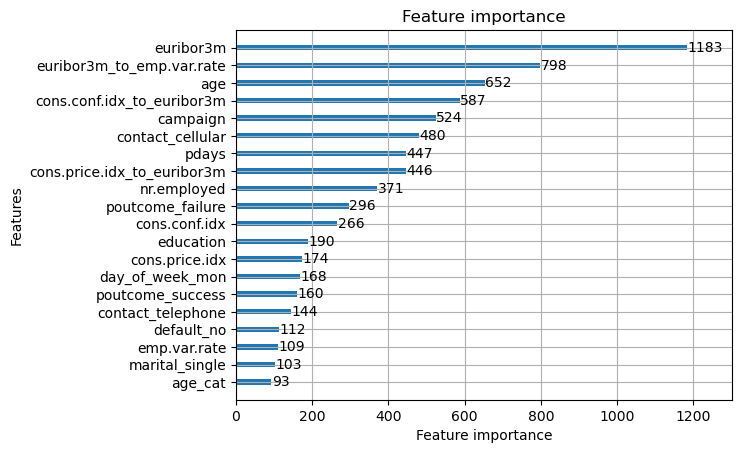

In [158]:
model_pipeline_lgb.fit(train_inputs, train_targets)

plot_importance(model_pipeline_lgb[-1], height=0.3, max_num_features=20)
plt.show()

**Conclusion on Feature Importance from LGBMClassifier**
-  Top Features:
    - `euribor3m` (1183) and `euribor3m_to_emp.var.rate` (798) – The most important predictors for the model. These features are related to economic indicators that likely impact customer behavior.
    Interest rates significantly impact financial decisions.
    - `age` (652) – Age remains a crucial factor in determining customer behavior.
    - `cons.conf.idx_to_euribor3m` (587) - A derived feature that captures consumer confidence relative to market rates. Could indicate customer sentiment towards financial services.
    -  `campaign` (524) – The number of contacts made during the campaign significantly affects the likelihood of a positive response.
    - `contact_cellular` (480) - Customers contacted via cellular may have different engagement levels compared to those contacted via telephone.
    -  likely capturing an important economic relationship between interest rates and employment.
    - `pdays` (447) and `poutcome_failure` (296) - Past interactions and their success/failure play a role in future engagement.
    
- Macroeconomic features (`euribor3m`, `nr.employed`, `emp.var.rate`) dominate, implying that economic conditions strongly influence customer decisions.
- Features related to marketing efforts (`campaign`, `contact_cellular`, `pdays`, `poutcome_failure`) are also relevant, which aligns with real-world bank marketing strategies. Suggesting that past interactions shape customer responses.
- Demographics and credit history (`age`, `education`, `default_no`) provide additional predictive power.
- Such results make sense because the top features based on economic and customer behavior factors.and align with financial decision-making.
- Feature importance confirms that economic conditions and marketing efforts play a crucial role.

## Shap Explainer

In [159]:
feat_eng(test_inputs)
test_inputs_transform = model_pipeline_lgb[0].transform(test_inputs)

In [87]:
explainer = shap.Explainer(model_pipeline_lgb[-1])
shap_values = explainer(test_inputs_transform)

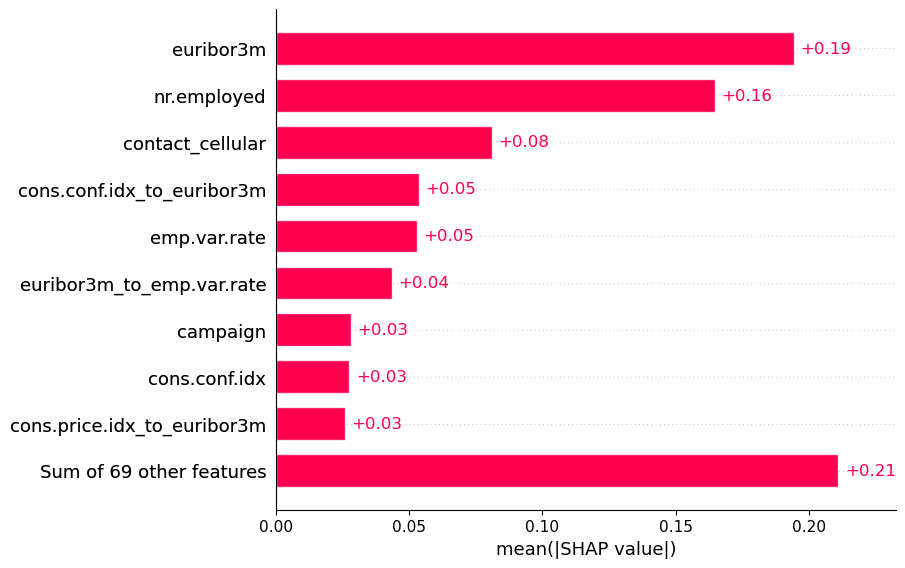

In [88]:
shap.plots.bar(shap_values)

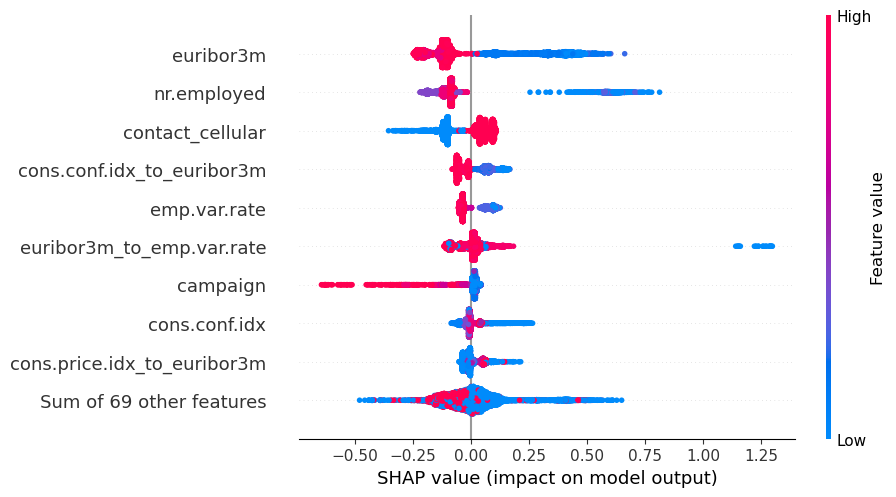

In [89]:
shap.plots.beeswarm(shap_values)

SHAP (Shapley Additive Explanations) helps us understand how each feature contributes to the model’s predictions:
- `euribor3m`, `nr.employed`, `emp.var.rate`, and `cons.conf.idx_to_euribor3m` - Higher values of these features increase the prediction probability (i.e., they increase the likelihood of a positive outcome). These are macroeconomic indicators, suggesting that a strong economy correlates with better customer engagement.
- `contact_cellular` - Customers contacted via cellular possibly more likely to respond positively. Might indicate that other contact methods (e.g., telephone) are less effective.
- `euribor3m_to_emp.var.rate` Most values do not significantly influence predictions, but some extreme blue values push predictions higher. This suggests that in some economic conditions, the interaction between euribor3m and emp.var.rate has a strong impact.
- `campaign` - Higher campaign values reduce the prediction (strong negative effect). Suggests that too many contact attempts decrease the likelihood of a positive outcome—likely due to customer annoyance.
- `cons.conf.idx` - Mixed effect. Indicates that consumer confidence has a non-linear impact—likely dependent on other conditions.

AUROC score on test set:: 0.761


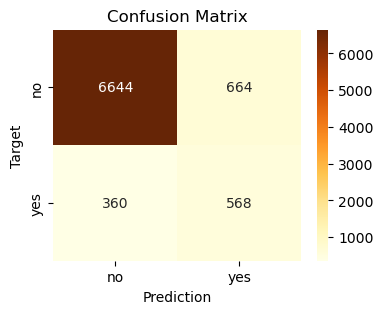

In [160]:
test_pred = model_pipeline_lgb.predict(test_inputs)
test_score = roc_auc_score(test_targets, test_pred)
print(f"AUROC score on test set:: {test_score:.3f}")

cm = confusion_matrix(test_targets, test_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, cmap='YlOrBr',
            xticklabels=['no', 'yes'], yticklabels=['no', 'yes'], fmt='.0f')
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title('Confusion Matrix')
plt.show()

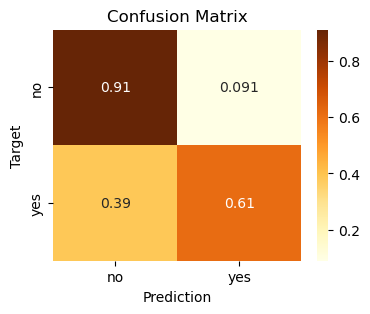

In [91]:
cm = confusion_matrix(test_targets, test_pred, normalize='true')
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, cmap='YlOrBr',
            xticklabels=['no', 'yes'], yticklabels=['no', 'yes'])
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.title('Confusion Matrix')
plt.show()

- Macroeconomic variables (`euribor3m`, `nr.employed`) significantly impact deposit subscription rates.
- Marketing strategies is crucial:
    - Contacting via cellular increases success.
    - Too many campaigns decrease effectiveness.
    - Recent interactions are more impactful.
- Feature engineering helped capture valuable economic trends.